# 会議割り当て問題

会議割り当て問題は、複数の会議のスケジュールと複数の会議室が与えられている場合に、なるべく多くの会議が開催できるように会議室を割り当てる問題です。本課題では、この問題に対応したQUBO模型を構築し、アニーリングマシンにより問題を解くことを考えます。

データとして、会議名をキーとし、その会議の開始・終了時間のリストのタプルを値とした辞書で会議スケジュールの情報を持つことにします。
ここでは時間は文字列で `"10:40"` の形式で与えられているとします。また、会議の数と、利用可能な会議室の数も定義しておきます。

In [12]:
token = "AE/rKyHjAKqvva0PLmfS2RfQ3EnIpY7lNze"  # ご自身のトークンを入力

In [1]:
# 会議のスケジュール
schedules = {
    "meeting1": ["10:00", "13:00"],
    "meeting2": ["10:00", "12:00"],
    "meeting3": ["10:00", "11:00"],
    "meeting4": ["11:00", "13:00"],
    "meeting5": ["11:00", "12:00"],
    "meeting6": ["11:00", "15:00"],
    "meeting7": ["12:00", "16:00"],
    "meeting8": ["12:00", "15:00"],
    "meeting9": ["13:00", "15:00"],
    "meeting10": ["13:00", "14:00"],
    "meeting11": ["14:00", "17:00"],
    "meeting12": ["15:00", "19:00"],
    "meeting13": ["15:00", "17:00"],
    "meeting14": ["15:00", "16:00"],
    "meeting15": ["16:00", "18:00"],
    "meeting16": ["16:00", "18:00"],
    "meeting17": ["17:00", "19:00"],
    "meeting18": ["17:00", "18:00"],
    "meeting19": ["18:00", "19:00"],
}

# 会議の数
Nm = len(schedules)

# 会議室の数
Nr = 8

次に、会議の時間を比べるために、与えられた時刻を数値で返す関数 `time2num` と、二つの会議のスケジュールが重なりあうかどうかをチェックする関数 `check_overlap` を用意します。

In [2]:
# 時刻を時間単位の数値に変換
def time2num(time: str):
    h, m = map(float, time.split(":"))
    return h + m / 60


# 2つの会議時間に重なりがあるかをチェック
def check_overlap(time_slot1: str, time_slot2: str):
    start1, end1 = map(time2num, time_slot1)
    start2, end2 = map(time2num, time_slot2)

    return start1 < end2 and start2 < end1

これで与えられた会議の情報を数値化する準備が整いました。次に、どのようにしてこの問題を組合せ最適化問題として表現するかを考えます。

まず基本方針として、各会議がどの会議室で開催されるかを変数で表すことを考えます。しかし、QUBOやイジングのような二値変数では任意の数の状態を持つことが出来ません。そこで、各会議に会議室の数だけ決定変数を割り当てます。

例えば、会議 $i$ を 会議室 $r$ で行うことを表す変数を $q_{i, r}$ とします。$q_{i, r} = 1$ であれば会議 $i$ を会議室 $r$ に割り当て、$q_{i, r} = 0$ であれば割り当てないと考えることができます。


|会議 \ 会議室| $0$ | $1$ | ... | $N_r-1$|  
|:---:|:---:|:---:|:---:|:---:|
|$0$| $q_{0,0}$ | $q_{0,1}$ | ... | $q_{0,N_r-1}$|
|$1$| $q_{1,0}$ | $q_{1,1}$ | ... | $q_{1,N_r-1}$|
|$\vdots$| $\vdots$ | $\vdots$ | ... | $\vdots$|
|$N_m -1$| $q_{N_m-1,0}$ | $q_{N_m-1,1}$ | ... | $q_{N_m-1,N_r-1}$|

次に、同じ会議室には複数の会議を重ねて割り当てることができないという制約について考えます。

スケジュールの重なりのある会議をまとめたリストを構築しておきます。例えば、会議 $i$ と $j$ にスケジュールの重なりがある場合、タプル $(i, j)$ を構築し、このリストに格納します。「スケジュールの重なりが無いように各会議を会議室に割り当てる問題」は、「二つの会議 $(i, j)$ が上記のリストに含まれる場合、同じ会議室を割り当てないように会議を配置する問題」となります。

次のようにして、上記に定義した `check_overlap` 関数を用いて会議のスケジュールの重なりを調べ、それをもとにスケジュールに重なりがある二つの会議 $(i, j)$ を `overlaps` リストに追加していきます。

In [3]:
import itertools

# 会議名のリストを取得
mtg_names = list(schedules.keys())

# 会議室名とインデックスの辞書を作成
mtg_name2idx = {mtg_names[i]: i for i in range(Nm)}

# スケジュールの重なりがある会議のインデックスをタプルで格納
overlaps = []
for mtg1, mtg2 in itertools.combinations(mtg_names, 2):
    if check_overlap(schedules[mtg1], schedules[mtg2]):
        overlaps.append(tuple(sorted([mtg_name2idx[mtg1], mtg_name2idx[mtg2]])))
overlaps[:5]

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

次に、`Nm` 個ある会議それぞれに `Nr` 個の会議室を対応させた、 `Nm x Nr` の形式のQUBO変数を定義します。会議のインデックス $i$、会議 $r$ に対応する変数を $q_{i, r}$ とします。

In [4]:
from amplify import BinarySymbolGenerator

# 決定変数を (N_mtg x N_rooms) の配列の形式で定義
gen = BinarySymbolGenerator()
q = gen.array(Nm, Nr)
q

[[  q_0,   q_1,   q_2,   q_3,   q_4,   q_5,   q_6,   q_7],
 [  q_8,   q_9,  q_10,  q_11,  q_12,  q_13,  q_14,  q_15],
 [ q_16,  q_17,  q_18,  q_19,  q_20,  q_21,  q_22,  q_23],
 [ q_24,  q_25,  q_26,  q_27,  q_28,  q_29,  q_30,  q_31],
 [ q_32,  q_33,  q_34,  q_35,  q_36,  q_37,  q_38,  q_39],
 [ q_40,  q_41,  q_42,  q_43,  q_44,  q_45,  q_46,  q_47],
 [ q_48,  q_49,  q_50,  q_51,  q_52,  q_53,  q_54,  q_55],
 [ q_56,  q_57,  q_58,  q_59,  q_60,  q_61,  q_62,  q_63],
 [ q_64,  q_65,  q_66,  q_67,  q_68,  q_69,  q_70,  q_71],
 [ q_72,  q_73,  q_74,  q_75,  q_76,  q_77,  q_78,  q_79],
 [ q_80,  q_81,  q_82,  q_83,  q_84,  q_85,  q_86,  q_87],
 [ q_88,  q_89,  q_90,  q_91,  q_92,  q_93,  q_94,  q_95],
 [ q_96,  q_97,  q_98,  q_99, q_100, q_101, q_102, q_103],
 [q_104, q_105, q_106, q_107, q_108, q_109, q_110, q_111],
 [q_112, q_113, q_114, q_115, q_116, q_117, q_118, q_119],
 [q_120, q_121, q_122, q_123, q_124, q_125, q_126, q_127],
 [q_128, q_129, q_130, q_131, q_132, q_133, q_134, q_135

QUBO変数を用いて制約条件を作成します。

まず、一つの会議は一つの会議室に割り当てられる必要があるので、

$
\displaystyle\sum_{r=0}^{\text{Nr} - 1}q_{i, r} = 1
$

という制約を課します。このように、いくつかの変数のうち $1$つだけが $1$ となる制約を one-hot 制約といいます。

さらに、二つの会議のインデックス $(i, j)$ が、 先ほど定義した会議スケジュールの重なりリスト `overlaps` に含まれている場合は、同じ会議室を割り当てることができないという制約を与える必要があります。

これは $(i, j)\in \text{overlaps}$ の場合は、$q_{i, r}$ と $q_{j, r}$ が同時に $1$ にならないという制約条件となるので、多項式で表すと

$
q_{i, r} q_{j, r} = 0 \qquad \text{for}\quad (i, j) \in \text{overlaps}, \  r \in \{0, \cdots, N_r - 1\}
$

という制約になります。

## 問題 1

一つの会議が一つの会議室に割り当てられる制約

$
\displaystyle\sum_{r=0}^{N_r - 1}q_{i, r} = 1
$

を構築してください。

会議のインデックスが取る値は $m = 0, 1, \cdots, N_m-1$ となるので、$N_m$ 個の制約条件からなるリストを生成する必要があります。
下記の `room_constraints` の `...` の部分を埋めてください。

ヒント:
* `one_hot` 関数を用いて one-hot 制約を実装してください。例えば、`one_hot([q[0], q[1], q[2]])` で $q_0 + q_1 + q_2=1$ の制約を課すオブジェクトを生成できます。

In [6]:
from amplify.constraint import one_hot

# 一つの会議に一つの会議室を割り当てるための one-hot 制約
room_constraints = [one_hot(q[i]) for i in range(Nm)]
room_constraints

[q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 == 1,
 q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_14 + q_15 == 1,
 q_16 + q_17 + q_18 + q_19 + q_20 + q_21 + q_22 + q_23 == 1,
 q_24 + q_25 + q_26 + q_27 + q_28 + q_29 + q_30 + q_31 == 1,
 q_32 + q_33 + q_34 + q_35 + q_36 + q_37 + q_38 + q_39 == 1,
 q_40 + q_41 + q_42 + q_43 + q_44 + q_45 + q_46 + q_47 == 1,
 q_48 + q_49 + q_50 + q_51 + q_52 + q_53 + q_54 + q_55 == 1,
 q_56 + q_57 + q_58 + q_59 + q_60 + q_61 + q_62 + q_63 == 1,
 q_64 + q_65 + q_66 + q_67 + q_68 + q_69 + q_70 + q_71 == 1,
 q_72 + q_73 + q_74 + q_75 + q_76 + q_77 + q_78 + q_79 == 1,
 q_80 + q_81 + q_82 + q_83 + q_84 + q_85 + q_86 + q_87 == 1,
 q_88 + q_89 + q_90 + q_91 + q_92 + q_93 + q_94 + q_95 == 1,
 q_96 + q_97 + q_98 + q_99 + q_100 + q_101 + q_102 + q_103 == 1,
 q_104 + q_105 + q_106 + q_107 + q_108 + q_109 + q_110 + q_111 == 1,
 q_112 + q_113 + q_114 + q_115 + q_116 + q_117 + q_118 + q_119 == 1,
 q_120 + q_121 + q_122 + q_123 + q_124 + q_125 + q_126 + q_127 == 1,
 q_128

## 問題2

スケジュールに重なりがある会議は同じ会議室に割り当てることができないという制約

$
q_{i, r} q_{j, r} = 0 \quad \text{for  } (i, j) \in \text{overlaps}, \ r \in \{0, \cdots, N_r - 1\}
$

を実装してください。以下の `overlap_constraints` の `...` の部分を埋めてください。

ヒント:
* `overlaps` にはスケジュールに重なりのある会議のインデックス $(i, j)$ が格納されています
* `equal_to` 関数を用いて $q_{i,r}q_{j, r}=0$ を実装してください。例えば、`equal_to(q[0, 0] * q[1, 0], 0)` で制約条件 $q_{0,0}q_{1,0} = 0$ が表現できます。




In [9]:
from amplify.constraint import equal_to

# overlaps内の全ての (i, j) で、q[i, r] * q[j, r] = 0 の制約条件を課す
overlap_constraints = [equal_to(q[i, r] * q[j, r], 0) for (i, j) in overlaps for r in range(Nr)]

上記で生成した二つの制約条件オブジェクト `room_one_hot` と `no_room_overlap` を足し、最終的に解くべき論理模型とします。

In [10]:
model = sum(room_constraints) + sum(overlap_constraints)

次に、クライアントを設定し、定義した模型を解きます。

In [13]:
from amplify import Solver
from amplify.client import FixstarsClient

# クライアントを設定
client = FixstarsClient()
client.parameters.timeout = 1000  # タイムアウト1秒
client.token = token

# ソルバーを設定
solver = Solver(client)
# 問題を解く
result = solver.solve(model)

# result が空の場合、制約条件を満たす解が得られなかったことを意味します
if len(result) == 0:
    raise RuntimeError("Given constraint conditions are not satisfied")

求めた解が $1$ となる変数から、各会議がどの会議室に割り当てられたかを読み取ることができます。

In [14]:
import numpy as np

# 求めた解を元の変数に代入
values = result[0].values
solution = q.decode(values)

# 各会議がどの会議室に割り当てられるかを読み取る

room_assignment = list(zip(*np.where(solution == 1)))

最後に結果を可視化します。

In [16]:
%matplotlib inline

In [17]:
#
# 会議室割り当てを可視化
#
import matplotlib.pyplot as plt


def plot_mtg_schedule(num_rooms, room_assignment):

    room_names = ["Room " + chr(65 + i) for i in range(num_rooms)]

    cmap = plt.get_cmap("coolwarm", num_rooms)
    colors = [cmap(i) for i in range(num_rooms)]

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    for mtg_idx, room in room_assignment:
        mtg_name = mtg_names[mtg_idx]
        start = time2num(schedules[mtg_name][0])
        end = time2num(schedules[mtg_name][1])

        plt.fill_between(
            [room + 0.55, room + 1.45],
            [start, start],
            [end, end],
            edgecolor="black",
            linewidth=3.0,
            facecolor=colors[room],
        )
        plt.text(
            room + 0.6, start + 0.1, f"{schedules[mtg_name][0]}", va="top", fontsize=10
        )
        plt.text(
            room + 1.0,
            (start + end) * 0.5,
            mtg_name,
            ha="center",
            va="center",
            fontsize=15,
        )

    # Set First Axis
    ax1.yaxis.grid()
    ax1.set_xlim(0.5, len(room_names) + 0.5)
    ax1.set_ylim(19.1, 7.9)
    ax1.set_xticks(range(1, len(room_names) + 1))
    ax1.set_xticklabels(room_names)
    ax1.set_ylabel("Time")

    # Set Second Axis
    ax2 = ax1.twiny().twinx()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(room_names)
    ax2.set_ylabel("Time")

    plt.show()

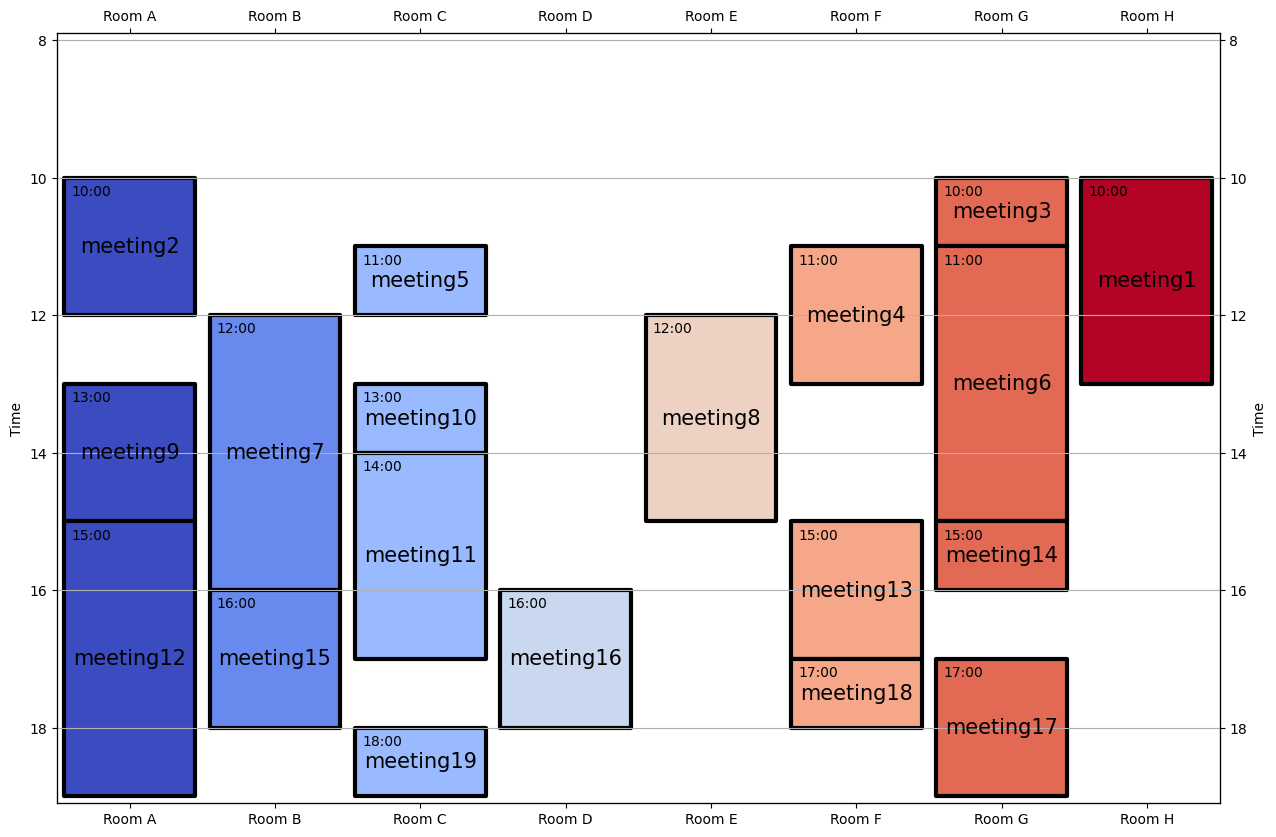

In [18]:
plot_mtg_schedule(num_rooms=Nr, room_assignment=room_assignment)

## 問題3

会議室の数 $N_r$ を変えて、結果がどのように変更されるか確認してください。
会議室の数を増やす場合は問題なく解を得ることができますが、ある程度減らすと解が求まらなくなります。

会議室はいくつまで減らすことが出来るでしょうか？

解が求まらない場合は、`result = solver.solve(model)` において、`len(result)` が 0 となることを確認してください。

## 発展課題

特定の会議を選び、それらの会議に会議室を手動で割り当ててください。例えば、

* meeting1 -> Room B
* meeting2 -> Room A
* meeting6 -> Room C
* meeting10 -> Room A
* meeting12 -> Room C
* meeting17 -> Room A

が事前に固定されているものとして、残りの会議室割り当てを決定してください。

* 得られた結果から、最初に指定した会議が意図した会議室に割り当てられていることを確認してください。

* 上の例で会議と会議室を固定すると、解が見つかる最小の会議室数は 6 となることを確認してください。

ヒント:

* 事前に決定変数の配列 `q` に値を入れておくことで固定化できます。例えば `q[i, j] = 1` としてください。
* One-hot 制約により、`q[i, j] = 1` とした場合その他のいくつかの変数が `0` で固定化できることに注意してください。